In [102]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
# train_iter是一个数据迭代器，每次迭代返回一个批次的数据，包含两部分：
# X：输入序列，形状为 (batch_size, num_steps) = (32, 35)
# Y：目标序列(预测目标)，形状也是 (32, 35)
# vocab 是一个词汇表对象，负责在文本和数字索引之间进行转换
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [103]:
# 了解形状以及具体用法
train_iter_temp, vocab_temp = d2l.load_data_time_machine(batch_size, num_steps)
for Xt, Yt in train_iter_temp:
    print(Xt)
    print(Xt.shape)
    # # 将一个批次的X转换回文本查看
    tokens = vocab_temp.to_tokens(Xt[0].tolist())
    print(''.join(tokens))  # 显示第一个序列的原始文本
    print(Yt)
    print(Yt.shape)
    # 在实际训练中，X作为输入，Y作为预测目标
    break  # 只查看第一批
# 输出词汇表大小
print(len(vocab))  # 词汇表大小，例如28(包括26个小写字母、空格和未知词元)
# 字符'e'对应的索引
print(vocab['e'])
 # 索引5对应的字符
print(vocab.idx_to_token[5])  # 索引5对应的字符，应为'e'

tensor([[ 3,  9,  2,  ...,  2,  1,  3],
        [15,  4, 14,  ...,  4,  6, 11],
        [17,  5,  3,  ...,  1,  4,  6],
        ...,
        [ 3,  1,  4,  ..., 12,  2, 13],
        [ 6,  3, 15,  ...,  5,  1, 13],
        [ 9,  2,  1,  ...,  4,  5, 10]])
torch.Size([32, 35])
the time machine by h g wellsithe t
tensor([[ 9,  2,  1,  ...,  1,  3,  5],
        [ 4, 14, 18,  ...,  6, 11, 20],
        [ 5,  3,  9,  ...,  4,  6, 11],
        ...,
        [ 1,  4,  1,  ...,  2, 13,  1],
        [ 3, 15, 10,  ...,  1, 13, 14],
        [ 2,  1, 13,  ...,  5, 10,  1]])
torch.Size([32, 35])
28
2
i


In [104]:
# 进行参数初始化
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    # 标准差为0.01的高斯分布
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xz, W_hz, b_z = three()  # 更新门参数
    W_xr, W_hr, b_r = three()  # 重置门参数
    W_xh, W_hh, b_h = three()  # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [105]:
# 隐状态的初始化函数
def init_gru_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [106]:
# 门循环单元模型
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [107]:
from torch.nn import functional as F
class RNNModelScratch:
    # 从零实现的RNN模型框架
    # 在本例中 前项传播函数forward_fn == gru
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    # 初始化参数方法
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [108]:
# 此方法来自d2l包
import math
from d2l.torch import grad_clipping

# RNN类模型在一个训练轮次中的训练过程
# 要训练的模型 数据迭代器 损失函数 参数更新器 计算设备 是否使用随机抽样的方式获取序列
def train_epoch_ch8(model, train_iter, loss, updater, device,
                    use_random_iter):
    # 初始化隐状态为None
    # 定义一个计时器 用于测量训练速度
    state, timer = None, d2l.Timer()
    # metric: 累加器，用于记录加权损失总和 处理的词元总数
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        # 在第一次迭代或随机抽样时初始化隐状态
        if state is None or use_random_iter:
            # 会调用init_gru_state方法
            state = model.begin_state(batch_size=X.shape[0], device=device)
        else:
            # # 分离隐藏状态，防止梯度在序列间传播
            if isinstance(model, nn.Module) and not isinstance(state, tuple):
                # 对于PyTorch的GRU，state是张量
                state.detach_()
            else:
                # 对于LSTM或自定义实现，state是张量元组
                for s in state:
                    s.detach_()
    # detach_() 方法是训练序列模型的关键技巧，它防止梯度在不同批次之间反向传播，解决了训练RNN时的长期依赖问题。
        # 将Y展平
        y = Y.T.reshape(-1)
        # 将数据移动到对应的设备
        X, y = X.to(device), y.to(device)
        # 执行前向传播，获得预测和新的隐藏状态
        y_hat, state = model(X, state)
        # 计算损失并取平均值
        # y.long(): 确保目标是长整型，CrossEntropyLoss要求目标是整数类别索引
        l = loss(y_hat, y.long()).mean()
        # PyTorch优化器：标准的梯度清零、反向传播、梯度裁剪、参数更新流程
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(model, 1)
            updater.step()
        else:
        # 自定义updater：执行反向传播和梯度裁剪后调用自定义更新函数
            l.backward()
            grad_clipping(model, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
            # 累计两个指标 加权损失：当前批次损失乘以词元数量 词元数量：用于计算平均损失
        metric.add(l * d2l.size(y), d2l.size(y))
    # 返回困惑度以及每秒处理的词元数
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [109]:
# 该函数在上一章已经写过注解了
def predict_ch8(prefix, num_preds, model, vocab, device):
    # 根据预输入片段生成预测
    state = model.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: d2l.reshape(d2l.tensor(
        [outputs[-1]], device=device), (1, 1))
    # 预热阶段
    for y in prefix[1:]:
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    # 生成阶段
    for _ in range(num_preds):
        y, state = model(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [110]:
import matplotlib.pyplot as plt

def train_ch8(model, train_iter, vocab, lr, num_epochs, device,
                   use_random_iter=False):
    # 创建两个列表跟踪每个epoch的困惑度 用于绘图
    epochs = []
    ppls = []

    # 使用交叉熵损失进行处理
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(model, nn.Module):
        # PyTorch模型：使用标准SGD优化器
        updater = torch.optim.SGD(model.parameters(), lr)
    else:
        # 自定义模型：使用函数式SGD实现
        updater = lambda batch_size: d2l.sgd(model.params, lr, batch_size)

    # 预测函数
    def predict(prefix):
        return d2l.predict_ch8(prefix, 50, model, vocab, device)

    # 训练循环
    for epoch in range(num_epochs):
        ppl, speed = d2l.train_epoch_ch8(
            model, train_iter, loss, updater, device, use_random_iter)
        # 更新列表中的轮次以及困惑度
        epochs.append(epoch + 1)
        ppls.append(ppl)

    # 训练完成后打印最终结果
    print(f'训练完成。最终困惑度: {ppl:.2f}, 速度: {speed:.1f} tokens/sec on {str(device)}')
    print('生成文本示例:')
    print(predict('time traveller'))

    # 训练完成后绘制困惑度曲线
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, ppls, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

训练完成。最终困惑度: 1.06, 速度: 120594.8 tokens/sec on cuda:0
生成文本示例:
time travellerit s against reason said filbywhat thes ohach he g


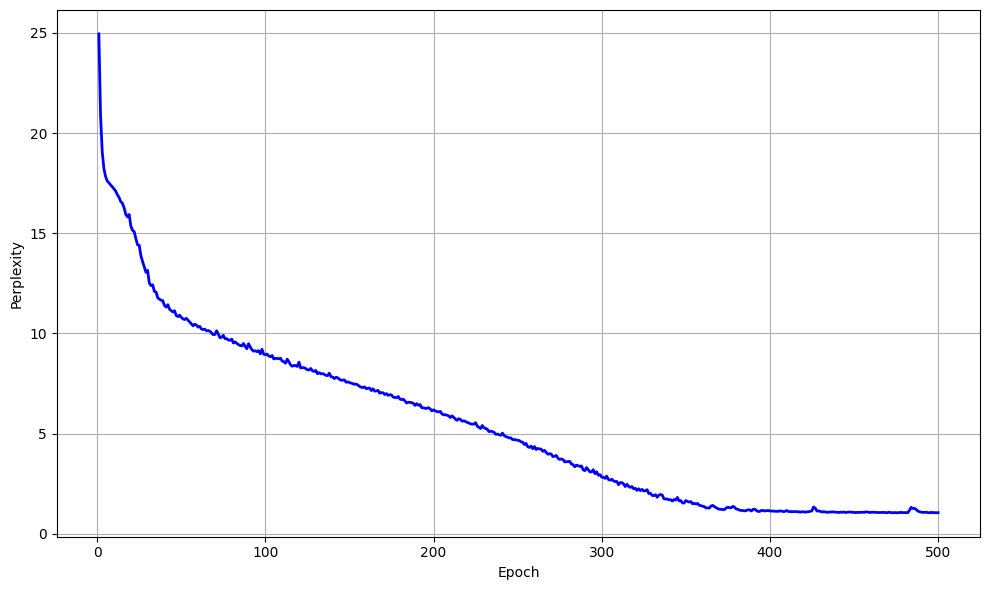

In [111]:
# 进行训练
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                            init_gru_state, gru)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [112]:
# 简洁实现对应pytorch封装RNN类
# 继承了nn.Module的神经网络模型
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        # 预构建的RNN层实例（可以是nn.RNN、nn.GRU或nn.LSTM）
        self.rnn = rnn_layer
        # 词表大小
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 对双向RNN的支持
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    # 前向传播
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        # 针对不不同的RNN变体进行状态初始化
        if not isinstance(self.rnn, nn.LSTM):
            # GRU/标准RNN（非LSTM）只需要单个隐藏状态张量
            # 形状为[num_directions * num_layers, batch_size, num_hiddens 初始值全为零
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # LSTM需要隐藏状态(h)和单元状态(c)两个张量 两个张量具有相同的形状和结构 以元组形式返回(h, c)
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

训练完成。最终困惑度: 1.04, 速度: 1091993.7 tokens/sec on cuda:0
生成文本示例:
time travelleryou can show black is white by argument said filby


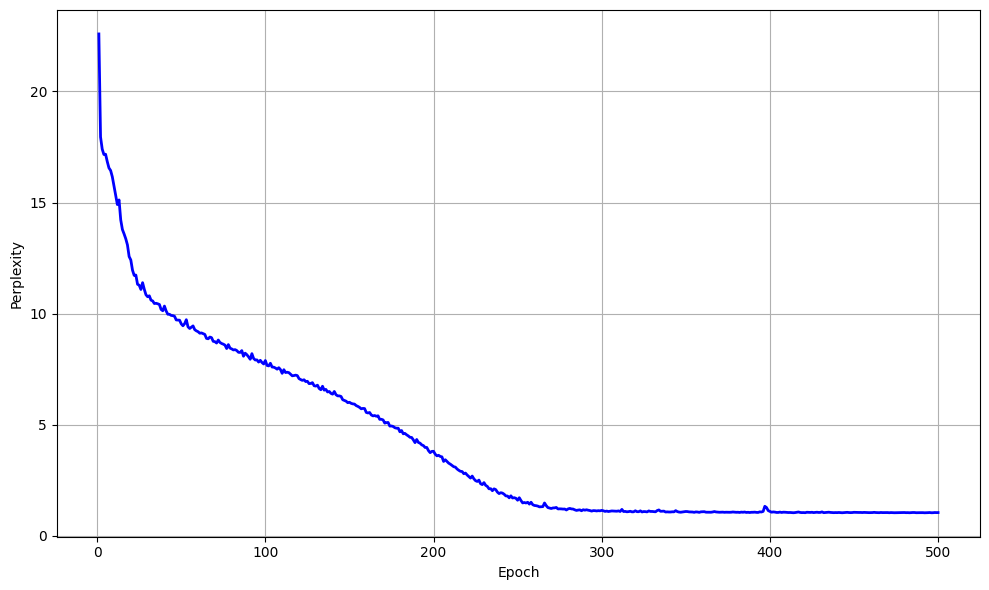

In [113]:
# 简洁实现
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# 数据维度变化详解：从输入到GRU模型的输出

本文详细解析了整个计算过程中，数据在GRU模型中的维度变化，结合上下文中已给出的具体参数：

### 参数上下文
- **`batch_size`**: 32
- **`num_steps`**: 35
- **`vocab_size`**: 28
- **`num_hiddens`**: 256
- **`num_layers`**: 1（单层GRU）
- **`num_directions`**: 1（单向GRU）

---

## 1. 输入数据维度

- **输入序列**: `X`
  - 形状: `[batch_size, num_steps]` → `[32, 35]`
  - 数据类型: 整数索引 (`torch.int64`)
  - 描述: 每行是一个序列，每个元素是词元的整数索引。

- **目标序列**: `y`
  - 形状: `[batch_size, num_steps]` → `[32, 35]`
  - 数据类型: 整数索引 (`torch.int64`)
  - 描述: 目标序列，通常是输入序列的偏移版本，用于计算下一时间步的预测。

---

## 2. 输入转置与独热编码

- **转置后的输入**: `X.T`
  - 形状: `[num_steps, batch_size]` → `[35, 32]`
  - 数据类型: 整数索引 (`torch.int64`)
  - 描述: 输入序列进行转置，使时间步维度 (`num_steps`) 在第一维，符合 PyTorch RNN 的输入要求。

- **独热编码后的输入**: `F.one_hot(X.T, vocab_size)`
  - 形状: `[num_steps, batch_size, vocab_size]` → `[35, 32, 28]`
  - 数据类型: 浮点数 (`torch.float32`)
  - 描述: 每个整数索引被转换为长度为 `vocab_size` 的独热向量，用于表示词元。

---

## 3. GRU层处理

- **GRU输入**: `X`
  - 形状: `[num_steps, batch_size, vocab_size]` → `[35, 32, 28]`
  - 数据类型: 浮点数 (`torch.float32`)
  - 描述: GRU层接收独热编码的序列输入。

- **隐藏状态序列输出**: `Y`
  - 形状: `[num_steps, batch_size, num_hiddens]` → `[35, 32, 256]`
  - 数据类型: 浮点数 (`torch.float32`)
  - 描述: 每个时间步的隐藏状态输出，包含上下文信息。

- **最终隐藏状态**: `state`
  - 形状: `[num_layers * num_directions, batch_size, num_hiddens]` → `[1, 32, 256]`
  - 数据类型: 浮点数 (`torch.float32`)
  - 描述: 最后时间步的隐藏状态，用于下一批次或序列的初始化。

---

## 4. 输出层处理

- **GRU输出重塑**: `Y.reshape((-1, Y.shape[-1]))`
  - 形状: `[num_steps * batch_size, num_hiddens]` → `[1120, 256]`
  - 描述: 将时间步和批次维度合并，为线性层准备输入。

- **线性层输出**: `self.linear(...)`
  - 形状: `[num_steps * batch_size, vocab_size]` → `[1120, 28]`
  - 描述: 将隐藏状态映射到词汇空间的logits，每行表示一个时间位置的预测分布。

---

## 5. 损失函数输入

- **预测输出**: `y_hat`
  - 形状: `[num_steps * batch_size, vocab_size]` → `[1120, 28]`
  - 描述: 由线性层输出的logits，用于计算损失。

- **目标标签**: `y`
  - 形状: `[batch_size, num_steps]` → `[32, 35]`
  - 转化后形状: `[num_steps * batch_size]` → `[1120]`
  - 描述: 目标序列展平成一维，与预测输出的每行一一对应。

---

## 总结

| **阶段**            | **变量名称**     | **形状 (通用)**                        | **形状 (实例参数)**                        | **描述**                                    |
|---------------------|------------------|-----------------------------------------|--------------------------------------------|---------------------------------------------|
| **原始输入**         | `X`             | `[batch_size, num_steps]`              | `[32, 35]`                                 | 每行是一个序列，元素为词元索引              |
| **目标标签**         | `y`             | `[batch_size, num_steps]`              | `[32, 35]`                                 | 目标序列，通常是`X`的偏移版本               |
| **转置后**           | `X.T`           | `[num_steps, batch_size]`              | `[35, 32]`                                 | 转置后的输入                                |
| **独热编码后**       | `F.one_hot`     | `[num_steps, batch_size, vocab_size]`  | `[35, 32, 28]`                             | 每个词元索引被转换为one-hot向量             |
| **GRU层输出**        | `Y`             | `[num_steps, batch_size, num_hiddens]` | `[35, 32, 256]`                            | 每个时间步的隐藏状态                        |
| **GRU最终状态**      | `state`         | `[num_layers*num_directions, batch_size, num_hiddens]` | `[1, 32, 256]`                   | GRU的最终隐藏状态                          |
| **重塑后**           | `Y.reshape`     | `[num_steps * batch_size, num_hiddens]`| `[1120, 256]`                              | 合并时间步和批次维度                        |
| **线性层输出**       | `output`/`y_hat`| `[num_steps * batch_size, vocab_size]` | `[1120, 28]`                               | 每行是一个时间步的预测分布                  |
| **目标展平**         | `y.reshape`     | `[num_steps * batch_size]`             | `[1120]`                                   | 展平成一维，与预测分布逐行对应              |

本文清晰展示了数据在GRU模型中的形状变化，为理解模型的输入输出关系提供了详细的参考。